In [ ]:
!pip install pysheds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.6 MB/s eta 0:00:00


In [ ]:
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from shapely.geometry import LineString
import geopandas as gpd

# Reading DEM

In [ ]:
grid = Grid.from_raster('Data/dem_Hesperange_BASIN.tif')
dem = grid.read_raster('Data/dem_Hesperange_BASIN.tif')

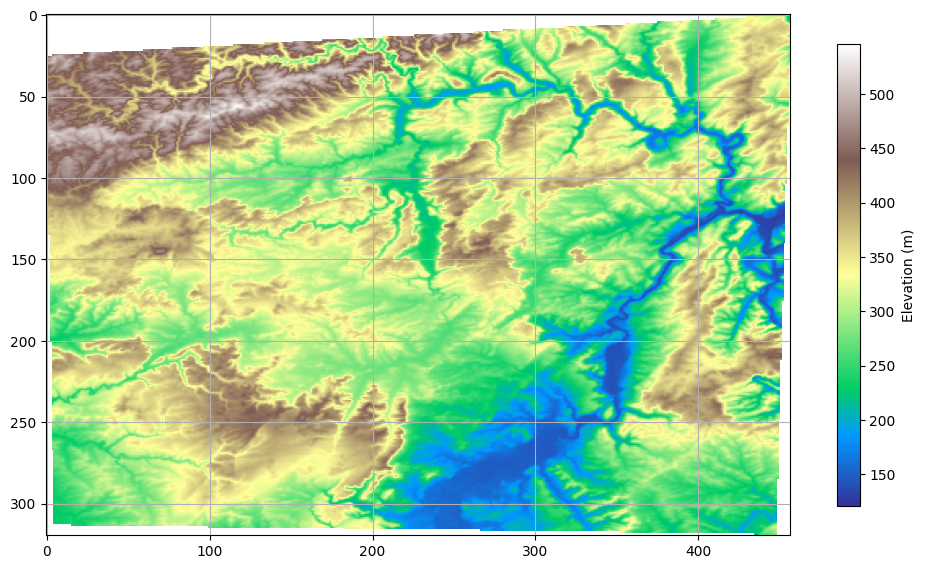

In [ ]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, cmap)
    plt.colorbar(label=label, shrink=0.6)
    plt.grid()

plotFigure(dem, 'Elevation (m)', 'terrain')

# Filling DEM

In [ ]:
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Directions

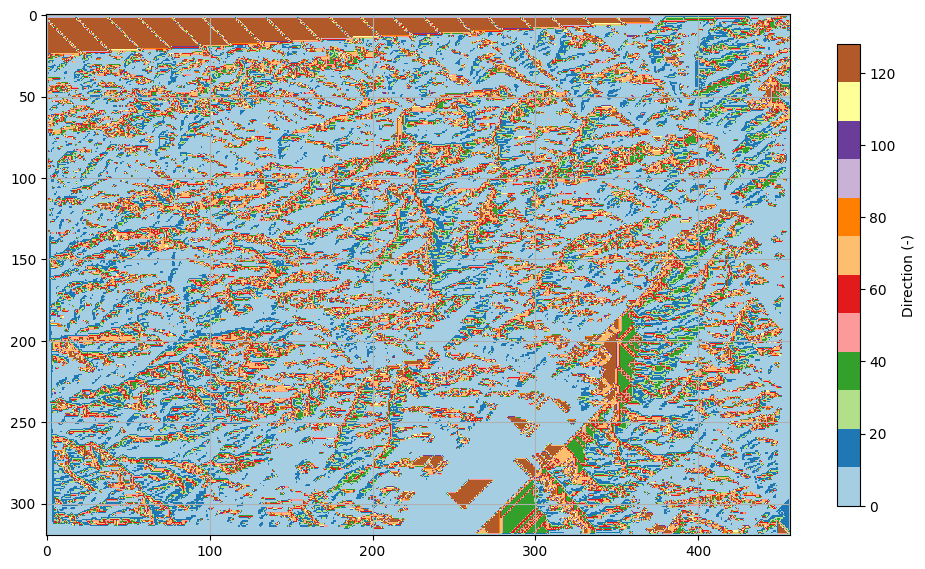

In [ ]:
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
plotFigure(fdir, 'Direction (-)', 'Paired')

# Flow accumulation

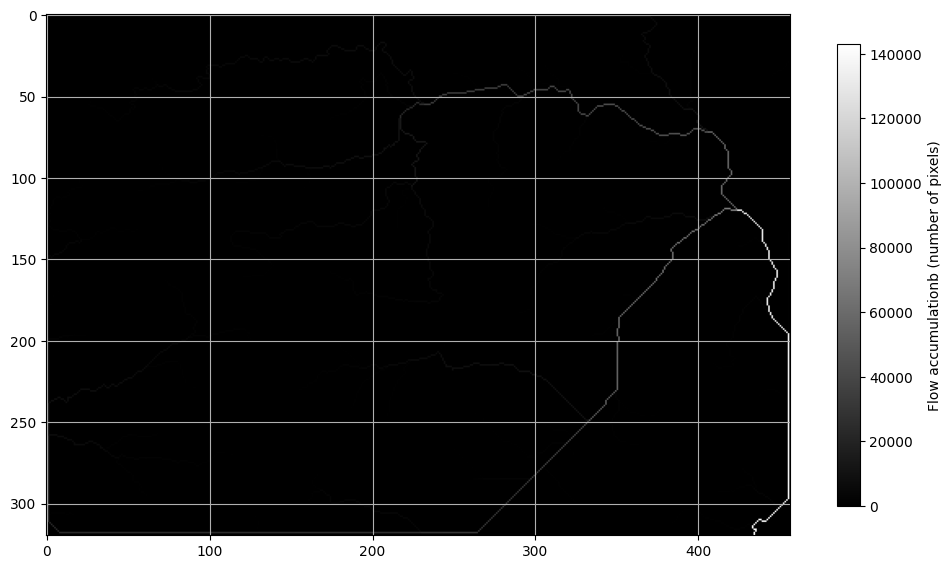

In [ ]:
acc = grid.accumulation(fdir, dirmap=dirmap)
plotFigure(acc, 'Flow accumulationb (number of pixels)', 'gray')

# export to tiff
grid.to_raster(acc, 'accumulation_image.tif')

# Catchment delination from flow direction

In [ ]:
x, y = 6.0982, 49.78811
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                       xytype='coordinate')

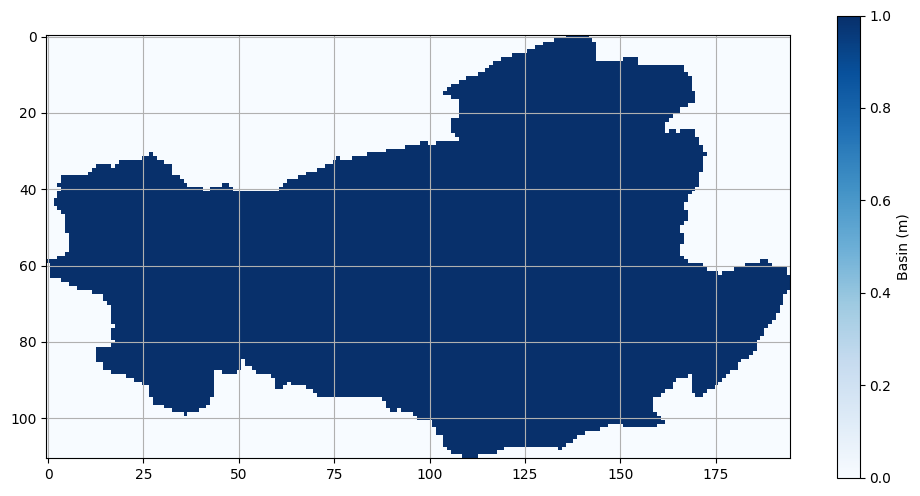

In [ ]:
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

plotFigure(clipped_catch, 'Basin (m)', 'Blues')

# Extract river network

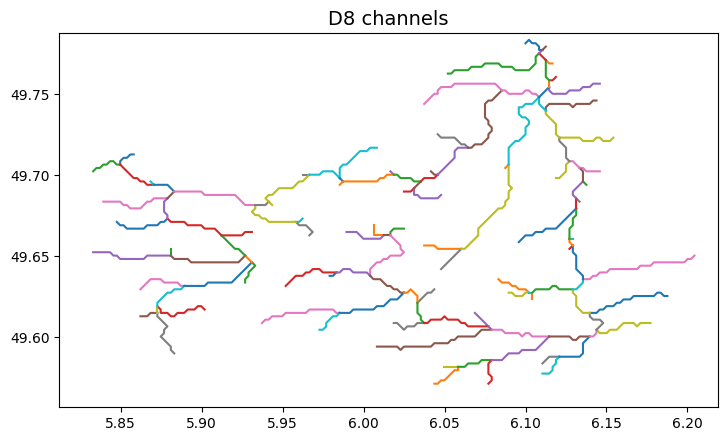

In [ ]:
# Extract river network
import numpy as np
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)
#sns.color_palette()

#sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title('D8 channels', size=14)

<Axes: >

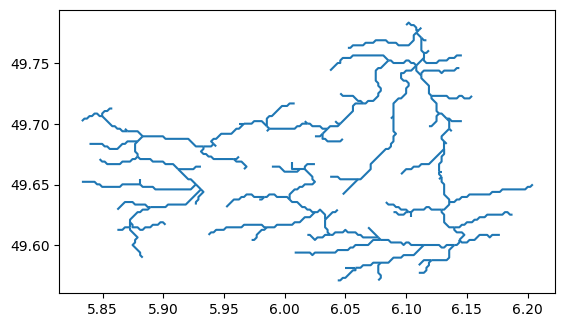

In [ ]:
line_strings = []

for branch in branches['features']:
    line_coords = branch['geometry']['coordinates']
    line = LineString(line_coords)
    line_strings.append(line)

gdf = gpd.GeoDataFrame(geometry=line_strings)
gdf.plot()

gdf.to_file('rivers.shp')